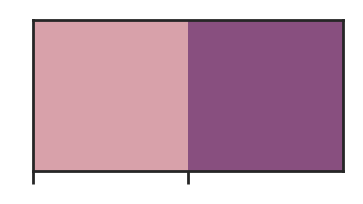

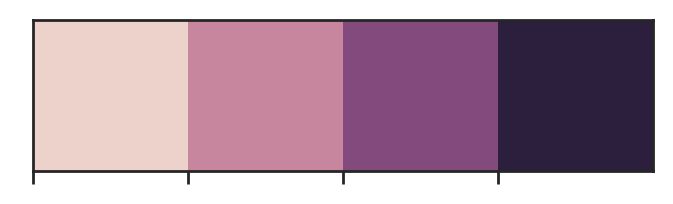

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

from scipy import interpolate
from sklearn import svm
from arviz import hpd

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="../data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 

#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Consistent color map throughout
cpal = sns.cubehelix_palette(4)
cmap = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)
tt_cmap = sns.cubehelix_palette(2, light=0.7, dark=0.4, as_cmap=True)
tt_cpal = sns.cubehelix_palette(2, light=0.7, dark=0.4, as_cmap=False)

sns.set_palette(cpal)
sns.palplot(tt_cpal)
sns.palplot(cpal)

/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  
/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/tdavid/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


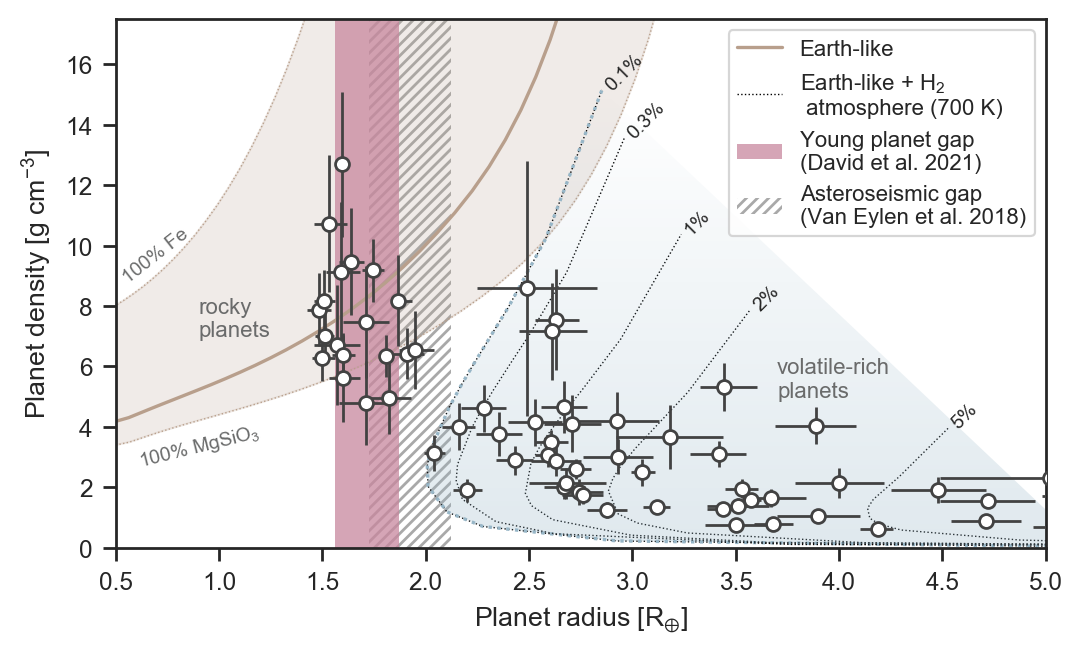

In [13]:
mearth = c.M_earth.cgs.value
rearth = c.R_earth.cgs.value

nea = get_catalog('planets')
nea.head()

mthresh = 0.2
rthresh = 0.2

nea['rho_gcc'] = nea['pl_masse']*mearth / (4./3.*np.pi*(nea['pl_rade']*rearth)**3.)

nsamples = 1000
_mp = np.array([np.random.normal(nea['pl_masse'], np.nanmax([nea['pl_masseerr2'], nea['pl_masseerr1']], axis=0)) for n in range(nsamples)])
_rp = np.array([np.random.normal(nea['pl_rade'], np.nanmax([nea['pl_radeerr2'], nea['pl_radeerr1']], axis=0)) for n in range(nsamples)])
_rho = (_mp*mearth)/(4./3.*np.pi*(_rp*rearth)**3.)

nea['rho_gcc'] = np.nanmean(_rho, axis=0)
nea['rho_gcc_err'] = np.nanstd(_rho, axis=0)

nea_m = (nea['pl_masseerr1']/nea['pl_masse']<mthresh) &\
        (nea['pl_masseerr2']/nea['pl_masse']<mthresh) &\
        (nea['pl_radeerr1']/nea['pl_rade']<rthresh) &\
        (nea['pl_radeerr2']/nea['pl_rade']<rthresh) &\
        (abs(nea['pl_radelim'])!=1) &\
        (abs(nea['pl_masselim'])!=1) &\
        (nea['pl_orbper']<100.) & (nea['st_teff']>4500) & (nea['st_teff']<6500)


def v18(p):
    logr = -0.09*np.log10(p)+0.37
    return 10.**logr

from scipy.interpolate import interp1d

import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 0.3 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(alpha, 0, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)
    return line, im


def zeng_curve(comp='earth'):
    
    url_dict = {"earth": "https://www.cfa.harvard.edu/~lzeng/tables/massradiusEarthlikeRocky.txt",
                "iron": "https://www.cfa.harvard.edu/~lzeng/tables/massradiusFe.txt",
                "rock": "https://www.cfa.harvard.edu/~lzeng/tables/massradiusmgsio3.txt"}
    
    data = Table.read(url_dict[comp], format="ascii")
    mass = data['col1']
    radius = data['col2']
    rho = mass*mearth / (4./3.*np.pi*(radius*rearth)**3.)
    
    r2rho = interp1d(radius, rho, fill_value='extrapolate')
    
    return mass,radius,rho,r2rho


def composition_plot(fig_path=None,
                     point_shade=False, 
                     ebar_kwargs={"fmt":'o', 
                                  "color":'white', 
                                  "mec":'#424242', 
                                  "ms":5, 
                                  "mew":1,
                                  "lw":1,
                                  "ecolor":'#424242', 
                                  "rasterized":True,
                                  "zorder": np.inf}):

    se_clr = '#b89f8c'
    sn_clr = '#97b6c7'
    
    if point_shade==True:
        plt.errorbar(nea['pl_rade'][nea_m], nea['rho_gcc'][nea_m],
                 xerr=[-nea['pl_radeerr2'][nea_m],nea['pl_radeerr1'][nea_m]],
                 yerr=nea['rho_gcc_err'][nea_m], fmt='.', color='k', lw=0.5, zorder=998, rasterized=True)
        
        
        plt.scatter(nea['pl_rade'][nea_m], nea['rho_gcc'][nea_m], 
                    c=nea['pl_orbper'][nea_m], cmap=cmap, zorder=999, edgecolors='k', vmin=1, vmax=20, rasterized=True)

        plt.colorbar(label='Orbital period [d]')
        
        plt.axvspan(1.56,1.87, color=tt_cpal[1], alpha=0.4, lw=0, label='Young planet gap\n(David et al. 2021)')
        plt.axvspan(v18(3),v18(30), color=tt_cpal[0], alpha=0.4, lw=0, label='Asteroseismic gap\n(Van Eylen et al. 2018)')
        
        
    elif point_shade==False:
        plt.errorbar(nea['pl_rade'][nea_m], nea['rho_gcc'][nea_m],
                     xerr=[-nea['pl_radeerr2'][nea_m], nea['pl_radeerr1'][nea_m]],
                     yerr=nea['rho_gcc_err'][nea_m], **ebar_kwargs)
        
        plt.axvspan(1.56,1.87, color=cpal[1], alpha=0.75, lw=0, label='Young planet gap\n(David et al. 2021)')
        plt.fill_between([v18(30),v18(3)],[18,18], facecolor="none", hatch="//////", edgecolor="darkgrey", linewidth=0.0, label='Asteroseismic gap\n(Van Eylen et al. 2018)')

        
    earth_m, earth_r, earth_rho, earth_r2rho = zeng_curve(comp='earth')
    rock_m, rock_r, rock_rho, rock_r2rho = zeng_curve(comp='rock')
    iron_m, iron_r, iron_rho, iron_r2rho = zeng_curve(comp='iron')
    
    _r = np.linspace(0.5,3.5,1000)
    plt.fill_between(_r, rock_r2rho(_r), iron_r2rho(_r), color=se_clr, alpha=0.2)
    plt.plot(earth_r, earth_rho, se_clr, label='Earth-like')
    plt.plot(rock_r, rock_rho, ls=':', lw=0.5, color=se_clr)
    plt.plot(iron_r, iron_rho, ls=':', lw=0.5, color=se_clr)

    labels = ['0.1%', '0.3%', '1%', '2%', '5%']
    for i,_t in enumerate(['01','03','1','2','5']):

        _zeng = Table.read("https://www.cfa.harvard.edu/~lzeng/tables/Earthlike"+_t+"h700K1mbar.txt", format="ascii")
        if i==0:
            label='Earth-like + H$_\mathregular{2}$\n atmosphere (700 K)'
        else:
            label=None
        _zeng_rho = _zeng['col1']*mearth / (4./3.*np.pi*(_zeng['col2']*rearth)**3)
        plt.plot(_zeng['col2'], _zeng_rho, 'k:', lw=0.5, label=label)
        plt.text(_zeng['col2'][-1], _zeng_rho[-1], labels[i], size=7, rotation=45)    

        if i==0:
            gradient_fill(_zeng['col2'], _zeng_rho, **{'color': sn_clr, 'ls':':'})        

    plt.text(0.9, 7, 'rocky\nplanets', color='#6a6b6b', size=8)
    plt.text(0.6, 2.7, '100% MgSiO$_\mathregular{3}$', color='#6a6b6b', size=7, rotation=14)
    plt.text(0.52, 8.8, '100% Fe', color='#6a6b6b', size=7, rotation=38)
    plt.text(3.7, 5, 'volatile-rich\nplanets', color='#6a6b6b', size=8)

    plt.ylabel('Planet density [g cm$^\mathregular{-3}$]')
    plt.xlabel(r'Planet radius [R$_\mathregular{\oplus}$]')
    plt.legend(prop={'size':8}, loc='best')
    plt.xlim(0.5,5)
    plt.ylim(0,17.5)

    plt.gcf().set_size_inches(6,3.5)
    if fig_path:
        plt.savefig(fig_path)
    plt.show()
    
composition_plot(fig_path='../figures/composition.pdf')